# `Практикум по программированию на языке Python`

## `Задание 03. Рекуррентные Нейронные Сети. Dropout. LM`

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__03 апреля 04:00__</span>.

Мягкий дедлайн: <span style="color:red">__18 апреля 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __7 баллов__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2023`

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# `Часть 0. Загрузка и предобработка данных (1 балл)`

## `Рекомендуемые гиперпараметры`

In [1]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать — скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## `Загрузка и предобработка данных`

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-04-22 18:07:48--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  10.2MB/s    in 8.5s    

2023-04-22 18:07:56 (9.43 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [3]:
!mkdir aclImdb
!tar -xzf aclImdb_v1.tar.gz aclImdb -C aclImdb

Посмотрите в файле `./aclImdb/README` как организованы данные:

In [4]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [4]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [5]:
import os
from functools import partial
from collections import defaultdict, OrderedDict

import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти — размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [6]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`, ...)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [7]:
def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    text = text.lower()
    text = regex.sub('(\<(/?[^>]+)>)', '', text)
    text = regex.sub('[^A-Za-z ]+', '', text)
    tokens = text.split(' ')
    tokens = [token for token in tokens if not(token in STOPWORDS) and len(token) > 0]
    return tokens

In [9]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab` и фабрика для создания таких классов `torchtext.vocab.vocab`.

In [10]:
torchtext.vocab.vocab??

Signature:
torchtext.vocab.vocab(
    ordered_dict: Dict,
    min_freq: int = 1,
    specials: Union[List[str], NoneType] = None,
    special_first: bool = True,
) -> torchtext.vocab.vocab.Vocab
Source:   
def vocab(
    ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True
) -> Vocab:
    r"""Factory method for creating a vocab object which maps tokens to indices.

    Note that the ordering in which key value pairs were inserted in the `ordered_dict` will be respected when building the vocab.
    Therefore if sorting by token frequency is important to the user, the `ordered_dict` should be created in a way to reflect this.

    Args:
        ordered_dict: Ordered Dictionary mapping tokens to their corresponding occurance frequencies.
        min_freq: The minimum frequency needed to include a token in the vocabulary.
        specials: Special symbols to add. The order of supplied tokens will be preserved.
        special_first: Indica

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [8]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [14]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

Создайте словарь из словаря частот `counter`. Наименьшие *id* отдайте под специальные токены. 

Отбросьте низкочастотные слова, оставив только `top_n_words` слов. Можете использовать любой способ реализации этого условия, например:
1. Оставить в словаре `counter` нужное число слов
2. Подобрать параметр `min_freq`, чтобы оставшееся число слов было близко к необходимому порогу

In [15]:
sorted_counter = sorted(counter.items(), key=lambda item: item[1], reverse=True)[:top_n_words]
vocab = torchtext.vocab.vocab(OrderedDict(sorted_counter), specials=specials)
vocab.set_default_index(1)

In [14]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [15]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 3, 1, 272]

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от $1$ до $10$. Для удобства, вычтите $1$, чтобы рейтинг был от $0$ до $9$

In [9]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            with open(path) as f:
              text = f.read()
              tokens = tokenize(text)
              ids = self.vocab.lookup_indices(tokens)
              if self.pad_sos:
                ids = [self.sos_id] + ids
              if self.pad_eos:
                ids = ids + [self.eos_id]
              if len(ids) > self.max_len:
                if self.pad_eos:
                  ids = ids[:(self.max_len - 1)] + [self.eos_id]
                else:
                  ids = ids[:self.max_len]
              rating = int(path[path.rfind('_') + 1: -4]) - 1
              self.texts.append(text)
              self.tokens.append(ids)
              self.ratings.append(rating)
              
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.Tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.Tensor(dtype=torch.long): rating of the text
                'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.Tensor(dtype=torch.long): number of tokens
            }
        """
        return {'text': self.texts[idx],
                     'label': torch.tensor(self.labels[idx], dtype=torch.long),
                     'rating': torch.tensor(self.ratings[idx], dtype=torch.long),
                     'tokens': torch.tensor(self.tokens[idx], dtype=torch.long),
                     'tokens_len': torch.tensor(len(self.tokens[idx]), dtype=torch.long)}
        
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        return len(self.labels)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [16]:
test_dataset = LargeMovieReviewDataset("./aclImdb/test", vocab, max_length)
train_dataset = LargeMovieReviewDataset("./aclImdb/train", vocab, max_length)

Посмотрим, как выглядит объект в датасете:

In [18]:
test_dataset[0]

{'text': 'This is an oft-used line, but it really sums up this movie..."If this is the current state of gay cinema, then we\'re in real trouble". I saw this film at SIFF because of the high IMDb rating (7.6) and if there was ever a case of vote stacking on IMDb, then this is it. Just watch the number fall over the release weeks of the film.<br /><br />Easy plot...Boy finds out his high school ex (boyfriend) is getting married to a female friend of theirs so he goes back to his old hometown (still carrying a 10 year old torch) to see what happened.<br /><br />First off, I liked "Latter Days", the director\'s last feature, despite its cookie cutter characters and plot contrivances, but you\'re supposed to become a better director with each subsequent release. I don\'t know how you get horrible supporting performances out of so many TV veterans (Robert Foxworth, Joanna Cassidy, Tori Spelling), but somehow he managed to. The writing was Lifetime Network quality (way back when they were REA

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` — число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [19]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [10]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.Tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.Tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.Tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    res_dict = {'ratings': [], 'labels': [], 'texts': [], 'tokens': [], 'tokens_lens' : []}
    for obj in batch:
      res_dict['ratings'] += [obj['rating']]
      res_dict['labels'] += [obj['label']]
      res_dict['texts'] += [obj['text']]
      res_dict['tokens'] += [obj['tokens']]
      res_dict['tokens_lens'] += [obj['tokens_len']]
    
    res_dict['ratings'] = torch.tensor(res_dict['ratings'], dtype=torch.long)
    res_dict['labels'] = torch.tensor(res_dict['labels'], dtype=torch.long)
    res_dict['tokens_lens'] = torch.tensor(res_dict['tokens_lens'], dtype=torch.long)
    res_dict['tokens'] = torch.nn.utils.rnn.pad_sequence(res_dict['tokens'],
                                                         batch_first=batch_first,
                                                         padding_value=padding_value)
    return res_dict

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [11]:
from functools import partial

In [17]:
collate_fn_part = partial(collate_fn, padding_value=vocab.lookup_indices(['<pad>'])[0], batch_first=False)

In [182]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn_part)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn_part)

Посмотрим на какой-нибудь батч:

In [24]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([2, 3, 2, 2, 3, 3, 1, 3, 0, 0, 1, 1, 0, 0, 3, 1, 2, 3, 2, 1, 2, 1, 0, 3,
         1, 3, 0, 3, 0, 1, 2, 3, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1,
         1, 0, 0, 1, 3, 0, 0, 1, 0, 3, 1, 3, 2, 0, 0, 1]),
 tensor([[   1,  215, 1076,  ...,  176,  364,  296],
         [ 253, 2305,    6,  ...,    2, 1600,   69],
         [  10,  355,  273,  ...,   78,  408,    2],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([170, 176, 118,  87,  65,  98,  89,  95,  57,  65,  65,  31, 200,  61,
          55,  35,  32, 200,  75, 200,  73,  70,  62,  15,  41, 175,  94,  2

# `Часть 1. Классификация текстов (4 балла)`

## `Сборка и обучение RNN в pytorch (1 балл)`

Создадим переменные для device-agnostic кода:

In [18]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-эмбеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [19]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        self.word_embeddings = torch.nn.Embedding(len(vocab), self.embedding_dim, device=device,
                                                  padding_idx=self.vocab.lookup_indices(['<pad>'])[0])
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        # Create linear layer for classification
        self.output = torch.nn.Linear(self.hidden_dim, self.output_size, device=device)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.Tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        #tokens: (max_len, batch_size), tokens_lens = (batch_size)
        # Evaluate embeddings
        embeddings = self.word_embeddings(tokens) #size:(max_len, batch_size, embedding_dim)
        # Make forward pass through recurrent network
        rnn = self.rnn(embeddings)[0] #size: (max_len, batch_size, hidden_dim)
        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        #size: (batch_size, hidden_dim)
        output = self.output(rnn[tokens_lens - 1, range(tokens.shape[1]), :]) # size: (batch_size, output_size)
        return torch.nn.functional.log_softmax(output, dim=1)

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [27]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        tokens, tokens_lens, ratings = data['tokens'], data['tokens_lens'], data['ratings']
        tokens = tokens.to(device)
        tokens_lens = tokens_lens.to(device)
        ratings = ratings.to(device)
        optimizer.zero_grad()
        output = model.forward(tokens, tokens_lens)
        loss = loss_fn(output, ratings)
        loss.backward()
        optimizer.step()

    
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            tokens, tokens_lens, ratings = data['tokens'], data['tokens_lens'], data['ratings']
            tokens = tokens.to(device)
            tokens_lens = tokens_lens.to(device)
            ratings = ratings.to(device)
            output = model.forward(tokens, tokens_lens)
            predict = torch.argmax(output, dim=1)
            loss = loss_fn(output, ratings).item() * len(ratings)
            accuracy = (ratings == predict).sum().item()
            total_loss += loss
            total_accuracy += accuracy
        
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [27]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [28]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [29]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 1.981/1.982. Accuracy (Train/Test): 0.243/0.251
Epoch: 2/15. Loss (Train/Test): 1.719/1.748. Accuracy (Train/Test): 0.347/0.343
Epoch: 3/15. Loss (Train/Test): 1.602/1.664. Accuracy (Train/Test): 0.382/0.360
Epoch: 4/15. Loss (Train/Test): 1.524/1.622. Accuracy (Train/Test): 0.411/0.376
Epoch: 5/15. Loss (Train/Test): 1.454/1.584. Accuracy (Train/Test): 0.432/0.386
Epoch: 6/15. Loss (Train/Test): 1.400/1.574. Accuracy (Train/Test): 0.449/0.386
Epoch: 7/15. Loss (Train/Test): 1.349/1.578. Accuracy (Train/Test): 0.470/0.394
Epoch: 8/15. Loss (Train/Test): 1.301/1.605. Accuracy (Train/Test): 0.495/0.378
Epoch: 9/15. Loss (Train/Test): 1.238/1.612. Accuracy (Train/Test): 0.527/0.375
Epoch: 10/15. Loss (Train/Test): 1.172/1.641. Accuracy (Train/Test): 0.556/0.371
Epoch: 11/15. Loss (Train/Test): 1.095/1.700. Accuracy (Train/Test): 0.575/0.383
Epoch: 12/15. Loss (Train/Test): 1.027/1.753. Accuracy (Train/Test): 0.611/0.372
Epoch: 13/15. Loss (Train/Test): 0.93

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют *L2-регуляризацию* и *дропаут*.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## `Реализация дропаута по статье Гала и Гарамани. Variational Dropout (1 балл)`

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

In [20]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    h0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    c0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    return h0, c0

In [21]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    if p is None:
        mask = some_existing_tensor.new_ones((input_size, hidden_size))
    else:
        if is_training:
            mask = torch.bernoulli(some_existing_tensor.new_full((input_size, hidden_size), 1 - p))
        else:
            mask = some_existing_tensor.new_full((input_size, hidden_size), 1 - p)
    return mask

Допишите класс-обёртку над `LSTMCell` для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [87]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        #x: (max_len, batch_size, embedding_dim)
        # Initialize h_0, c_0
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        # Gen masks for input and hidden state
        input_mask = gen_dropout_mask(x.shape[1], self.input_size, self.training, self.dropout, x)
        hidden_mask = gen_dropout_mask(x.shape[1], self.hidden_size, self.training, self.dropout, x)
        # Implement recurrent logic and return what nn.LSTM returns
        out = []
        for t in range(x.shape[0]):
            h_0 = h_0 * hidden_mask
            x_t = x[t] * input_mask
            h_0, c_0 = self.rnn_cell(x_t, (h_0, c_0))
            out.append(h_0)
        out = torch.stack(out)
        return out, (h_0, c_0)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [34]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=None
).to(device)

In [35]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 1.923/1.933. Accuracy (Train/Test): 0.292/0.293
Epoch: 2/15. Loss (Train/Test): 1.792/1.817. Accuracy (Train/Test): 0.327/0.326
Epoch: 3/15. Loss (Train/Test): 1.626/1.689. Accuracy (Train/Test): 0.370/0.356
Epoch: 4/15. Loss (Train/Test): 1.531/1.625. Accuracy (Train/Test): 0.402/0.374
Epoch: 5/15. Loss (Train/Test): 1.498/1.610. Accuracy (Train/Test): 0.416/0.381
Epoch: 6/15. Loss (Train/Test): 1.434/1.583. Accuracy (Train/Test): 0.434/0.387
Epoch: 7/15. Loss (Train/Test): 1.376/1.587. Accuracy (Train/Test): 0.457/0.392
Epoch: 8/15. Loss (Train/Test): 1.315/1.593. Accuracy (Train/Test): 0.477/0.380
Epoch: 9/15. Loss (Train/Test): 1.245/1.594. Accuracy (Train/Test): 0.513/0.390
Epoch: 10/15. Loss (Train/Test): 1.180/1.611. Accuracy (Train/Test): 0.538/0.389
Epoch: 11/15. Loss (Train/Test): 1.124/1.649. Accuracy (Train/Test): 0.567/0.385
Epoch: 12/15. Loss (Train/Test): 1.047/1.715. Accuracy (Train/Test): 0.596/0.385
Epoch: 13/15. Loss (Train/Test): 0.98

Время обучения увеличилось более чем в 2 раза

Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [88]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [89]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 2.009/2.011. Accuracy (Train/Test): 0.231/0.233
Epoch: 2/15. Loss (Train/Test): 1.840/1.849. Accuracy (Train/Test): 0.315/0.318
Epoch: 3/15. Loss (Train/Test): 1.703/1.724. Accuracy (Train/Test): 0.349/0.349
Epoch: 4/15. Loss (Train/Test): 1.616/1.654. Accuracy (Train/Test): 0.373/0.365
Epoch: 5/15. Loss (Train/Test): 1.562/1.610. Accuracy (Train/Test): 0.394/0.378
Epoch: 6/15. Loss (Train/Test): 1.522/1.587. Accuracy (Train/Test): 0.402/0.385
Epoch: 7/15. Loss (Train/Test): 1.480/1.561. Accuracy (Train/Test): 0.422/0.390
Epoch: 8/15. Loss (Train/Test): 1.454/1.552. Accuracy (Train/Test): 0.427/0.397
Epoch: 9/15. Loss (Train/Test): 1.425/1.536. Accuracy (Train/Test): 0.444/0.396
Epoch: 10/15. Loss (Train/Test): 1.398/1.526. Accuracy (Train/Test): 0.447/0.405
Epoch: 11/15. Loss (Train/Test): 1.391/1.537. Accuracy (Train/Test): 0.448/0.406
Epoch: 12/15. Loss (Train/Test): 1.356/1.515. Accuracy (Train/Test): 0.468/0.406
Epoch: 13/15. Loss (Train/Test): 1.34

Разница между accuracy на обучении и контроле уменьшилась примерно до 0.1 по сравнению с примерно 0.35 у модели без дропатуа, то есть переобучение получилось побороть. Время генерации по сравнению с моделью без дропаута изменилось несильно, скорее всего это связано с тем, что функция для генерации масок всё равно вызывается.

## `Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)`

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде умножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [22]:
import warnings

In [23]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')
            # Generate mask (use function gen_dropout_mask)
            dropout_mask = gen_dropout_mask(raw_w.shape[0], raw_w.shape[1], self.training,
                                             self.dropout, x)
            
            # Apply dropout mask
            masked_raw_w = raw_w * dropout_mask
            
            # Set modified weights in its place
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            self._setweights(x)
            if h_c is None:
                output = self.module.forward(x)
            else:
                output = self.module.forward(x, h_c)
        return output
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [64]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=None
).to(device)


loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 2.014/2.017. Accuracy (Train/Test): 0.218/0.210
Epoch: 2/15. Loss (Train/Test): 1.782/1.801. Accuracy (Train/Test): 0.333/0.334
Epoch: 3/15. Loss (Train/Test): 1.640/1.680. Accuracy (Train/Test): 0.365/0.353
Epoch: 4/15. Loss (Train/Test): 1.562/1.642. Accuracy (Train/Test): 0.390/0.366
Epoch: 5/15. Loss (Train/Test): 1.473/1.585. Accuracy (Train/Test): 0.423/0.384
Epoch: 6/15. Loss (Train/Test): 1.430/1.583. Accuracy (Train/Test): 0.442/0.377
Epoch: 7/15. Loss (Train/Test): 1.369/1.561. Accuracy (Train/Test): 0.468/0.391
Epoch: 8/15. Loss (Train/Test): 1.306/1.559. Accuracy (Train/Test): 0.488/0.399
Epoch: 9/15. Loss (Train/Test): 1.262/1.587. Accuracy (Train/Test): 0.509/0.390
Epoch: 10/15. Loss (Train/Test): 1.190/1.638. Accuracy (Train/Test): 0.534/0.391
Epoch: 11/15. Loss (Train/Test): 1.113/1.675. Accuracy (Train/Test): 0.572/0.386
Epoch: 12/15. Loss (Train/Test): 1.053/1.715. Accuracy (Train/Test): 0.597/0.374
Epoch: 13/15. Loss (Train/Test): 0.96

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [90]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=0.25
).to(device)


loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 1.966/1.970. Accuracy (Train/Test): 0.271/0.274
Epoch: 2/15. Loss (Train/Test): 1.929/1.950. Accuracy (Train/Test): 0.310/0.306
Epoch: 3/15. Loss (Train/Test): 1.744/1.769. Accuracy (Train/Test): 0.342/0.339
Epoch: 4/15. Loss (Train/Test): 1.665/1.715. Accuracy (Train/Test): 0.361/0.355
Epoch: 5/15. Loss (Train/Test): 1.604/1.669. Accuracy (Train/Test): 0.378/0.364
Epoch: 6/15. Loss (Train/Test): 1.581/1.662. Accuracy (Train/Test): 0.386/0.364
Epoch: 7/15. Loss (Train/Test): 1.520/1.621. Accuracy (Train/Test): 0.405/0.378
Epoch: 8/15. Loss (Train/Test): 1.483/1.604. Accuracy (Train/Test): 0.415/0.379
Epoch: 9/15. Loss (Train/Test): 1.472/1.623. Accuracy (Train/Test): 0.424/0.384
Epoch: 10/15. Loss (Train/Test): 1.427/1.602. Accuracy (Train/Test): 0.437/0.395
Epoch: 11/15. Loss (Train/Test): 1.406/1.599. Accuracy (Train/Test): 0.449/0.396
Epoch: 12/15. Loss (Train/Test): 1.374/1.583. Accuracy (Train/Test): 0.458/0.395
Epoch: 13/15. Loss (Train/Test): 1.35

</конец взлома pytorch>

Качество обеих моделей получилось таким же, как и в первом случае. Время обучения уменьшилось по сранению с предыдущей моделью и стало близко ко времени обучения оригинальной модели.

## `Реализация дропаута по статье Семениуты и др. (1 балл)`

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток ($m_h$ — маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t)
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [92]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x) #(batch_size, hidden_size)
        mask = gen_dropout_mask(x.shape[1], self.hidden_size, self.training, self.dropout, x)
        input_mask = gen_dropout_mask(x.shape[1], self.input_size, self.training, self.dropout, x)
        #x: (max_len, batch_size, embegging_dim)
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        
        output = []
        for t in range(x.shape[0]):
            x_t = x[t] * input_mask
            a = self.input_weights(x_t) + self.hidden_weights(h_0)#(batch_size, 4 * hidden_size)
            i = torch.special.expit(a[:, :self.hidden_size]) #(batch_size, hidden_size)
            f = torch.special.expit(a[:, self.hidden_size: 2 * self.hidden_size])
            g = torch.tanh(a[:, 2 * self.hidden_size: 3 * self.hidden_size])
            o = torch.special.expit(a[:, 3 * self.hidden_size:])
            c_0 = f * c_0 + i * g * mask
            h_0 = o * torch.tanh(c_0)
            output.append(h_0)
        return torch.stack(output), (h_0, c_0)

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [95]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=None
).to(device)


loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [96]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 2.015/2.014. Accuracy (Train/Test): 0.234/0.234
Epoch: 2/15. Loss (Train/Test): 1.740/1.769. Accuracy (Train/Test): 0.341/0.340
Epoch: 3/15. Loss (Train/Test): 1.608/1.668. Accuracy (Train/Test): 0.373/0.359
Epoch: 4/15. Loss (Train/Test): 1.513/1.602. Accuracy (Train/Test): 0.409/0.381
Epoch: 5/15. Loss (Train/Test): 1.483/1.594. Accuracy (Train/Test): 0.422/0.372
Epoch: 6/15. Loss (Train/Test): 1.409/1.553. Accuracy (Train/Test): 0.451/0.393
Epoch: 7/15. Loss (Train/Test): 1.365/1.562. Accuracy (Train/Test): 0.469/0.393
Epoch: 8/15. Loss (Train/Test): 1.343/1.584. Accuracy (Train/Test): 0.478/0.387
Epoch: 9/15. Loss (Train/Test): 1.278/1.580. Accuracy (Train/Test): 0.499/0.382
Epoch: 10/15. Loss (Train/Test): 1.217/1.597. Accuracy (Train/Test): 0.525/0.387
Epoch: 11/15. Loss (Train/Test): 1.173/1.658. Accuracy (Train/Test): 0.543/0.386
Epoch: 12/15. Loss (Train/Test): 1.120/1.684. Accuracy (Train/Test): 0.554/0.395
Epoch: 13/15. Loss (Train/Test): 1.02

Качество модели уменьшилось несколько сотых по сравнию с предыдущими версиями. Время обучения - самое большое из всех представленных, примерно в 7 раз больше, чем у обычной модели.

In [93]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=0.25
).to(device)


loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [94]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 2.009/2.011. Accuracy (Train/Test): 0.239/0.246
Epoch: 2/15. Loss (Train/Test): 1.855/1.867. Accuracy (Train/Test): 0.304/0.309
Epoch: 3/15. Loss (Train/Test): 1.670/1.701. Accuracy (Train/Test): 0.356/0.354
Epoch: 4/15. Loss (Train/Test): 1.638/1.680. Accuracy (Train/Test): 0.372/0.364
Epoch: 5/15. Loss (Train/Test): 1.555/1.614. Accuracy (Train/Test): 0.401/0.379
Epoch: 6/15. Loss (Train/Test): 1.523/1.602. Accuracy (Train/Test): 0.404/0.377
Epoch: 7/15. Loss (Train/Test): 1.470/1.567. Accuracy (Train/Test): 0.423/0.393
Epoch: 8/15. Loss (Train/Test): 1.446/1.547. Accuracy (Train/Test): 0.429/0.401
Epoch: 9/15. Loss (Train/Test): 1.421/1.544. Accuracy (Train/Test): 0.440/0.403
Epoch: 10/15. Loss (Train/Test): 1.402/1.542. Accuracy (Train/Test): 0.445/0.407
Epoch: 11/15. Loss (Train/Test): 1.375/1.533. Accuracy (Train/Test): 0.457/0.406
Epoch: 12/15. Loss (Train/Test): 1.360/1.534. Accuracy (Train/Test): 0.465/0.406
Epoch: 13/15. Loss (Train/Test): 1.34

Качество модели с данным дроупаутом такое же, как и у моделей с другим дропаутом, но при этом время обучения значительно дольше(такой же порядок, как и у модели без дропаута)

## `Сравнение всех предложенных моделей (1 балл)`

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 3min 5s       | 8min 33s| 3min 9s     | 21m 47s      |

In [100]:
#костыль
k = ['''Epoch: 1/15. Loss (Train/Test): 1.981/1.982. Accuracy (Train/Test): 0.243/0.251
Epoch: 2/15. Loss (Train/Test): 1.719/1.748. Accuracy (Train/Test): 0.347/0.343
Epoch: 3/15. Loss (Train/Test): 1.602/1.664. Accuracy (Train/Test): 0.382/0.360
Epoch: 4/15. Loss (Train/Test): 1.524/1.622. Accuracy (Train/Test): 0.411/0.376
Epoch: 5/15. Loss (Train/Test): 1.454/1.584. Accuracy (Train/Test): 0.432/0.386
Epoch: 6/15. Loss (Train/Test): 1.400/1.574. Accuracy (Train/Test): 0.449/0.386
Epoch: 7/15. Loss (Train/Test): 1.349/1.578. Accuracy (Train/Test): 0.470/0.394
Epoch: 8/15. Loss (Train/Test): 1.301/1.605. Accuracy (Train/Test): 0.495/0.378
Epoch: 9/15. Loss (Train/Test): 1.238/1.612. Accuracy (Train/Test): 0.527/0.375
Epoch: 10/15. Loss (Train/Test): 1.172/1.641. Accuracy (Train/Test): 0.556/0.371
Epoch: 11/15. Loss (Train/Test): 1.095/1.700. Accuracy (Train/Test): 0.575/0.383
Epoch: 12/15. Loss (Train/Test): 1.027/1.753. Accuracy (Train/Test): 0.611/0.372
Epoch: 13/15. Loss (Train/Test): 0.931/1.829. Accuracy (Train/Test): 0.660/0.364
Epoch: 14/15. Loss (Train/Test): 0.854/1.902. Accuracy (Train/Test): 0.693/0.363
Epoch: 15/15. Loss (Train/Test): 0.773/1.989. Accuracy (Train/Test): 0.732/0.354''',
'''Epoch: 1/15. Loss (Train/Test): 1.923/1.933. Accuracy (Train/Test): 0.292/0.293
Epoch: 2/15. Loss (Train/Test): 1.792/1.817. Accuracy (Train/Test): 0.327/0.326
Epoch: 3/15. Loss (Train/Test): 1.626/1.689. Accuracy (Train/Test): 0.370/0.356
Epoch: 4/15. Loss (Train/Test): 1.531/1.625. Accuracy (Train/Test): 0.402/0.374
Epoch: 5/15. Loss (Train/Test): 1.498/1.610. Accuracy (Train/Test): 0.416/0.381
Epoch: 6/15. Loss (Train/Test): 1.434/1.583. Accuracy (Train/Test): 0.434/0.387
Epoch: 7/15. Loss (Train/Test): 1.376/1.587. Accuracy (Train/Test): 0.457/0.392
Epoch: 8/15. Loss (Train/Test): 1.315/1.593. Accuracy (Train/Test): 0.477/0.380
Epoch: 9/15. Loss (Train/Test): 1.245/1.594. Accuracy (Train/Test): 0.513/0.390
Epoch: 10/15. Loss (Train/Test): 1.180/1.611. Accuracy (Train/Test): 0.538/0.389
Epoch: 11/15. Loss (Train/Test): 1.124/1.649. Accuracy (Train/Test): 0.567/0.385
Epoch: 12/15. Loss (Train/Test): 1.047/1.715. Accuracy (Train/Test): 0.596/0.385
Epoch: 13/15. Loss (Train/Test): 0.980/1.747. Accuracy (Train/Test): 0.630/0.378
Epoch: 14/15. Loss (Train/Test): 0.908/1.822. Accuracy (Train/Test): 0.668/0.361
Epoch: 15/15. Loss (Train/Test): 0.843/1.938. Accuracy (Train/Test): 0.694/0.362''',
'''Epoch: 1/15. Loss (Train/Test): 2.009/2.011. Accuracy (Train/Test): 0.231/0.233
Epoch: 2/15. Loss (Train/Test): 1.840/1.849. Accuracy (Train/Test): 0.315/0.318
Epoch: 3/15. Loss (Train/Test): 1.703/1.724. Accuracy (Train/Test): 0.349/0.349
Epoch: 4/15. Loss (Train/Test): 1.616/1.654. Accuracy (Train/Test): 0.373/0.365
Epoch: 5/15. Loss (Train/Test): 1.562/1.610. Accuracy (Train/Test): 0.394/0.378
Epoch: 6/15. Loss (Train/Test): 1.522/1.587. Accuracy (Train/Test): 0.402/0.385
Epoch: 7/15. Loss (Train/Test): 1.480/1.561. Accuracy (Train/Test): 0.422/0.390
Epoch: 8/15. Loss (Train/Test): 1.454/1.552. Accuracy (Train/Test): 0.427/0.397
Epoch: 9/15. Loss (Train/Test): 1.425/1.536. Accuracy (Train/Test): 0.444/0.396
Epoch: 10/15. Loss (Train/Test): 1.398/1.526. Accuracy (Train/Test): 0.447/0.405
Epoch: 11/15. Loss (Train/Test): 1.391/1.537. Accuracy (Train/Test): 0.448/0.406
Epoch: 12/15. Loss (Train/Test): 1.356/1.515. Accuracy (Train/Test): 0.468/0.406
Epoch: 13/15. Loss (Train/Test): 1.340/1.519. Accuracy (Train/Test): 0.468/0.410
Epoch: 14/15. Loss (Train/Test): 1.317/1.517. Accuracy (Train/Test): 0.481/0.409
Epoch: 15/15. Loss (Train/Test): 1.292/1.512. Accuracy (Train/Test): 0.489/0.410''',
'''Epoch: 1/15. Loss (Train/Test): 2.014/2.017. Accuracy (Train/Test): 0.218/0.210
Epoch: 2/15. Loss (Train/Test): 1.782/1.801. Accuracy (Train/Test): 0.333/0.334
Epoch: 3/15. Loss (Train/Test): 1.640/1.680. Accuracy (Train/Test): 0.365/0.353
Epoch: 4/15. Loss (Train/Test): 1.562/1.642. Accuracy (Train/Test): 0.390/0.366
Epoch: 5/15. Loss (Train/Test): 1.473/1.585. Accuracy (Train/Test): 0.423/0.384
Epoch: 6/15. Loss (Train/Test): 1.430/1.583. Accuracy (Train/Test): 0.442/0.377
Epoch: 7/15. Loss (Train/Test): 1.369/1.561. Accuracy (Train/Test): 0.468/0.391
Epoch: 8/15. Loss (Train/Test): 1.306/1.559. Accuracy (Train/Test): 0.488/0.399
Epoch: 9/15. Loss (Train/Test): 1.262/1.587. Accuracy (Train/Test): 0.509/0.390
Epoch: 10/15. Loss (Train/Test): 1.190/1.638. Accuracy (Train/Test): 0.534/0.391
Epoch: 11/15. Loss (Train/Test): 1.113/1.675. Accuracy (Train/Test): 0.572/0.386
Epoch: 12/15. Loss (Train/Test): 1.053/1.715. Accuracy (Train/Test): 0.597/0.374
Epoch: 13/15. Loss (Train/Test): 0.961/1.779. Accuracy (Train/Test): 0.635/0.380
Epoch: 14/15. Loss (Train/Test): 0.882/1.878. Accuracy (Train/Test): 0.672/0.376
Epoch: 15/15. Loss (Train/Test): 0.834/1.967. Accuracy (Train/Test): 0.699/0.355''',
'''Epoch: 1/15. Loss (Train/Test): 1.966/1.970. Accuracy (Train/Test): 0.271/0.274
Epoch: 2/15. Loss (Train/Test): 1.929/1.950. Accuracy (Train/Test): 0.310/0.306
Epoch: 3/15. Loss (Train/Test): 1.744/1.769. Accuracy (Train/Test): 0.342/0.339
Epoch: 4/15. Loss (Train/Test): 1.665/1.715. Accuracy (Train/Test): 0.361/0.355
Epoch: 5/15. Loss (Train/Test): 1.604/1.669. Accuracy (Train/Test): 0.378/0.364
Epoch: 6/15. Loss (Train/Test): 1.581/1.662. Accuracy (Train/Test): 0.386/0.364
Epoch: 7/15. Loss (Train/Test): 1.520/1.621. Accuracy (Train/Test): 0.405/0.378
Epoch: 8/15. Loss (Train/Test): 1.483/1.604. Accuracy (Train/Test): 0.415/0.379
Epoch: 9/15. Loss (Train/Test): 1.472/1.623. Accuracy (Train/Test): 0.424/0.384
Epoch: 10/15. Loss (Train/Test): 1.427/1.602. Accuracy (Train/Test): 0.437/0.395
Epoch: 11/15. Loss (Train/Test): 1.406/1.599. Accuracy (Train/Test): 0.449/0.396
Epoch: 12/15. Loss (Train/Test): 1.374/1.583. Accuracy (Train/Test): 0.458/0.395
Epoch: 13/15. Loss (Train/Test): 1.352/1.595. Accuracy (Train/Test): 0.467/0.398
Epoch: 14/15. Loss (Train/Test): 1.348/1.605. Accuracy (Train/Test): 0.463/0.399
Epoch: 15/15. Loss (Train/Test): 1.300/1.588. Accuracy (Train/Test): 0.484/0.404''',
'''Epoch: 1/15. Loss (Train/Test): 2.015/2.014. Accuracy (Train/Test): 0.234/0.234
Epoch: 2/15. Loss (Train/Test): 1.740/1.769. Accuracy (Train/Test): 0.341/0.340
Epoch: 3/15. Loss (Train/Test): 1.608/1.668. Accuracy (Train/Test): 0.373/0.359
Epoch: 4/15. Loss (Train/Test): 1.513/1.602. Accuracy (Train/Test): 0.409/0.381
Epoch: 5/15. Loss (Train/Test): 1.483/1.594. Accuracy (Train/Test): 0.422/0.372
Epoch: 6/15. Loss (Train/Test): 1.409/1.553. Accuracy (Train/Test): 0.451/0.393
Epoch: 7/15. Loss (Train/Test): 1.365/1.562. Accuracy (Train/Test): 0.469/0.393
Epoch: 8/15. Loss (Train/Test): 1.343/1.584. Accuracy (Train/Test): 0.478/0.387
Epoch: 9/15. Loss (Train/Test): 1.278/1.580. Accuracy (Train/Test): 0.499/0.382
Epoch: 10/15. Loss (Train/Test): 1.217/1.597. Accuracy (Train/Test): 0.525/0.387
Epoch: 11/15. Loss (Train/Test): 1.173/1.658. Accuracy (Train/Test): 0.543/0.386
Epoch: 12/15. Loss (Train/Test): 1.120/1.684. Accuracy (Train/Test): 0.554/0.395
Epoch: 13/15. Loss (Train/Test): 1.029/1.732. Accuracy (Train/Test): 0.601/0.387
Epoch: 14/15. Loss (Train/Test): 0.963/1.786. Accuracy (Train/Test): 0.632/0.383
Epoch: 15/15. Loss (Train/Test): 0.896/1.863. Accuracy (Train/Test): 0.666/0.372''',
'''Epoch: 1/15. Loss (Train/Test): 2.009/2.011. Accuracy (Train/Test): 0.239/0.246
Epoch: 2/15. Loss (Train/Test): 1.855/1.867. Accuracy (Train/Test): 0.304/0.309
Epoch: 3/15. Loss (Train/Test): 1.670/1.701. Accuracy (Train/Test): 0.356/0.354
Epoch: 4/15. Loss (Train/Test): 1.638/1.680. Accuracy (Train/Test): 0.372/0.364
Epoch: 5/15. Loss (Train/Test): 1.555/1.614. Accuracy (Train/Test): 0.401/0.379
Epoch: 6/15. Loss (Train/Test): 1.523/1.602. Accuracy (Train/Test): 0.404/0.377
Epoch: 7/15. Loss (Train/Test): 1.470/1.567. Accuracy (Train/Test): 0.423/0.393
Epoch: 8/15. Loss (Train/Test): 1.446/1.547. Accuracy (Train/Test): 0.429/0.401
Epoch: 9/15. Loss (Train/Test): 1.421/1.544. Accuracy (Train/Test): 0.440/0.403
Epoch: 10/15. Loss (Train/Test): 1.402/1.542. Accuracy (Train/Test): 0.445/0.407
Epoch: 11/15. Loss (Train/Test): 1.375/1.533. Accuracy (Train/Test): 0.457/0.406
Epoch: 12/15. Loss (Train/Test): 1.360/1.534. Accuracy (Train/Test): 0.465/0.406
Epoch: 13/15. Loss (Train/Test): 1.343/1.526. Accuracy (Train/Test): 0.466/0.413
Epoch: 14/15. Loss (Train/Test): 1.325/1.522. Accuracy (Train/Test): 0.473/0.414
Epoch: 15/15. Loss (Train/Test): 1.308/1.531. Accuracy (Train/Test): 0.482/0.413''']

train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for s in k:
    a = []
    b = []
    c = []
    d = []
    for r in s.split('\n'):
        a.append(float(r[-11:-6]))
        b.append(float(r[-5:]))
        c.append(float(r[-47:-42]))
        d.append(float(r[-41:-36]))
    train_accuracy.append(a)
    test_accuracy.append(b)
    train_loss.append(c)
    test_loss.append(d)

In [40]:
import matplotlib.pyplot as plt

Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [41]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  """


Нарисуйте два графика — функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

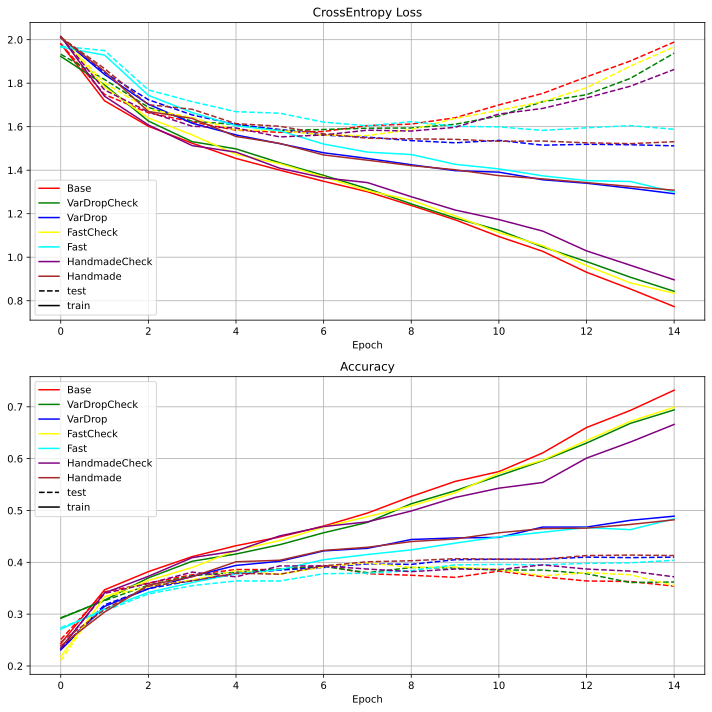

In [106]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

x = list(range(15))
labels = ["Base", "VarDropCheck", "VarDrop", "FastCheck", "Fast", "HandmadeCheck", "Handmade"]
colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'purple', 'brown']
plt.subplot(2, 1, 1)
for i in range(7):
    plt.plot(x, train_loss[i], label=labels[i], color=colors[i])
    plt.plot(x, test_loss[i], color=colors[i], linestyle='--')

plt.plot([], [], linestyle='--', label="test", color='black')
plt.plot([], [], label="train", color='black')

plt.subplot(2, 1, 2)
for i in range(7):
    plt.plot(x, train_accuracy[i], label=labels[i], color=colors[i])
    plt.plot(x, test_accuracy[i], color=colors[i], linestyle='--')
plt.plot([], [], linestyle='--', label="test", color='black')
plt.plot([], [], label="train", color='black')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:**
Дропаут помогает побороть переобучние, при его использовании качество на тренировочной выборке выше по сравнению с обычной моделью. Разные реализации дропаута дают почти одинаковое качество, однако время обучения различается в значительной степени.

## `Бонус. Zoneout (0.5 балла)`

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью $p$ компонента скрытого состояния обновляется, а с вероятностью $1-p$ берется с предыдущего шага. 
В Виде формул ($m^t_h$ - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

**Полный балл ставится только при наличии качественного и количественного сравнения с предыдущими моделями.**

In [97]:
class ZoneoutRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        #x: (max_len, batch_size, embedding_dim)
        # Initialize h_0, c_0
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        # Gen masks for input and hidden state
        input_mask = gen_dropout_mask(x.shape[1], self.input_size, self.training, self.dropout, x)
        # Implement recurrent logic and return what nn.LSTM returns
        out = []
        for t in range(x.shape[0]):
            x_t = x[t] * input_mask
            h_prev = h_0
            h_0, c_0 = self.rnn_cell(x_t, (h_0, c_0))
            out.append(h_0)
            hidden_mask = gen_dropout_mask(x.shape[1], self.hidden_size, self.training, self.dropout, x)
            h_0 = h_0 * hidden_mask + h_prev * (1 - hidden_mask)
        out = torch.stack(out)
        return out, (h_0, c_0)

In [98]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=ZoneoutRNNLayer, dropout=None
).to(device)


loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [99]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

Epoch: 1/15. Loss (Train/Test): 1.972/1.972. Accuracy (Train/Test): 0.258/0.263
Epoch: 2/15. Loss (Train/Test): 1.838/1.854. Accuracy (Train/Test): 0.323/0.323
Epoch: 3/15. Loss (Train/Test): 1.655/1.696. Accuracy (Train/Test): 0.361/0.356
Epoch: 4/15. Loss (Train/Test): 1.561/1.640. Accuracy (Train/Test): 0.397/0.370
Epoch: 5/15. Loss (Train/Test): 1.515/1.623. Accuracy (Train/Test): 0.409/0.358
Epoch: 6/15. Loss (Train/Test): 1.446/1.603. Accuracy (Train/Test): 0.438/0.385
Epoch: 7/15. Loss (Train/Test): 1.367/1.582. Accuracy (Train/Test): 0.464/0.390
Epoch: 8/15. Loss (Train/Test): 1.302/1.560. Accuracy (Train/Test): 0.496/0.394
Epoch: 9/15. Loss (Train/Test): 1.234/1.610. Accuracy (Train/Test): 0.519/0.392
Epoch: 10/15. Loss (Train/Test): 1.183/1.640. Accuracy (Train/Test): 0.538/0.390
Epoch: 11/15. Loss (Train/Test): 1.119/1.662. Accuracy (Train/Test): 0.564/0.395
Epoch: 12/15. Loss (Train/Test): 1.049/1.709. Accuracy (Train/Test): 0.597/0.382
Epoch: 13/15. Loss (Train/Test): 0.95

Качество при отсутствиии дропаута такое же, как и у предыдущих моделей. Модель сделана на основе RNNLayer, и время обучения по сравнению с этой версией больше примерно в 1.5 раза. Однако оно всё равно меньше времени обучения Handmade версии.

In [102]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=ZoneoutRNNLayer, dropout=0.25
).to(device)


loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [104]:
%%time

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)

Epoch: 1/15. Loss (Train/Test): 2.019/2.022. Accuracy (Train/Test): 0.220/0.215
Epoch: 2/15. Loss (Train/Test): 1.909/1.926. Accuracy (Train/Test): 0.286/0.286
Epoch: 3/15. Loss (Train/Test): 1.725/1.757. Accuracy (Train/Test): 0.360/0.337
Epoch: 4/15. Loss (Train/Test): 1.594/1.642. Accuracy (Train/Test): 0.384/0.367
Epoch: 5/15. Loss (Train/Test): 1.539/1.603. Accuracy (Train/Test): 0.402/0.379
Epoch: 6/15. Loss (Train/Test): 1.480/1.564. Accuracy (Train/Test): 0.423/0.390
Epoch: 7/15. Loss (Train/Test): 1.442/1.543. Accuracy (Train/Test): 0.434/0.399
Epoch: 8/15. Loss (Train/Test): 1.419/1.544. Accuracy (Train/Test): 0.442/0.406
Epoch: 9/15. Loss (Train/Test): 1.392/1.533. Accuracy (Train/Test): 0.450/0.406
Epoch: 10/15. Loss (Train/Test): 1.357/1.518. Accuracy (Train/Test): 0.466/0.406
Epoch: 11/15. Loss (Train/Test): 1.339/1.522. Accuracy (Train/Test): 0.470/0.410
Epoch: 12/15. Loss (Train/Test): 1.329/1.524. Accuracy (Train/Test): 0.472/0.408
Epoch: 13/15. Loss (Train/Test): 1.29

Время обучения стало больше на 1 минуту по сравнению в версией без дропаута. Качество на обучающей выборке выше на несколько сотых по сравнинию с другими моделями, на тестовой - почти такое, как и у других моделей, хотя и немного выше.

# `Часть 2. Language Modeling с помощью LSTM (5 баллов)`

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации — конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## `Реализация модели и цикла обучения (2 балла)`

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [24]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: 
            Batch of texts represented with tokens. Shape: [T, B]
        :param torch.Tensor(dtype=torch.long) tokens_lens: 
            Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.Tensor: 
            Distribution of next token for each time step. Shape: [T, B, V], V — size of vocabulary
        """
        # Make embeddings for all tokens
        embeddings = self.word_embeddings(tokens)
        # Forward pass embeddings through network
        rnn = self.rnn(embeddings)[0]
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        output = self.output(rnn)
        return output

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [19]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [20]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [25]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, (tokens_lens - 1).to('cpu').numpy(),
                                                                 batch_first=False,
                                                                 enforce_sorted=False).data
        
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], (tokens_lens - 1).to('cpu').numpy(),
                                                                batch_first=False,
                                                                enforce_sorted=False).data
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        return super().forward(packed_outputs, packed_tokens)

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [26]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, (tokens_lens - 1).to('cpu').numpy(),
                                                                 batch_first=False,
                                                                 enforce_sorted=False).data
        
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], (tokens_lens - 1).to('cpu').numpy(),
                                                                batch_first=False,
                                                                enforce_sorted=False).data
        accuracy = (packed_outputs.argmax(dim=1) == packed_tokens).sum().item()
        return accuracy
        

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [27]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        tokens, tokens_lens = data['tokens'], data['tokens_lens']
        tokens = tokens.to(device)
        tokens_lens = tokens_lens.to(device)
        optimizer.zero_grad()
        output = model.forward(tokens, tokens_lens)
        loss = loss_fn(output, tokens, tokens_lens)
        loss.backward()
        optimizer.step()
    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            tokens, tokens_lens = data['tokens'], data['tokens_lens']
            tokens = tokens.to(device)
            tokens_lens = tokens_lens.to(device)
            output = model.forward(tokens, tokens_lens)
            loss = loss_fn(output, tokens, tokens_lens)
            accuracy = accuracy_fn(output, tokens, tokens_lens)
            total_loss += loss * tokens_lens.sum()
            total_accuracy += accuracy
            total_tokens += tokens_lens.sum()
            
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [28]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
# min_freq=8 is approximately equivalent to max_size=30000. 
#   You can lower min_freq in order to make model vocabulary more diverse 
lm_vocab = torchtext.vocab.vocab(counter, specials=specials, special_first=True, min_freq=8)
lm_vocab.set_default_index(1)

In [29]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [30]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце — `<eos>` токен.

In [31]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [ 3566,   157,  4546,  ...,  1687,  2397,  2557],
         [  149,  1698,  4190,  ...,    68,   708,   512],
         ...,
         [  233,   711,   101,  ...,   761,   867, 16591],
         [  157, 20414,    47,  ...,   538,  4578,  2269],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20]))

Создадим модель, функцию потерь и оптимизатор: 

In [31]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [32]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [33]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

Epoch: 1/10. Loss (Train/Test): 7.395/7.549. Accuracy (Train/Test): 0.092/0.092
Epoch: 2/10. Loss (Train/Test): 7.097/7.381. Accuracy (Train/Test): 0.098/0.097
Epoch: 3/10. Loss (Train/Test): 6.897/7.340. Accuracy (Train/Test): 0.100/0.097
Epoch: 4/10. Loss (Train/Test): 6.619/7.258. Accuracy (Train/Test): 0.110/0.105
Epoch: 5/10. Loss (Train/Test): 6.389/7.258. Accuracy (Train/Test): 0.115/0.107
Epoch: 6/10. Loss (Train/Test): 6.142/7.283. Accuracy (Train/Test): 0.121/0.108
Epoch: 7/10. Loss (Train/Test): 5.954/7.349. Accuracy (Train/Test): 0.126/0.106
Epoch: 8/10. Loss (Train/Test): 5.709/7.387. Accuracy (Train/Test): 0.136/0.110
Epoch: 9/10. Loss (Train/Test): 5.503/7.459. Accuracy (Train/Test): 0.146/0.109
Epoch: 10/10. Loss (Train/Test): 5.346/7.550. Accuracy (Train/Test): 0.155/0.106


## `Реализация декодера (1 балл)`

Теперь, реализуем последнюю деталь — декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [179]:
@torch.no_grad()
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum lenght of generated samples
    :param Optional[int] top_k: Number of tokens with the largest probability to sample from
    :return Tuple[torch.Tensor, torch.Tensor]. 
        Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    embedding = model.word_embeddings(start_tokens) #(max_len, batch_size, embedding_dim)
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        output, (h, c) = model.rnn(embedding[time_step][None, :, :], (h, c))
        all_h.append(h)
        all_c.append(c)
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = model.output(h[-1])
        logits[:, model.vocab['<unk>']] = -1e10
        loguts = torch.softmax(logits, dim=1)
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            # YOUR CODE HERE
            next_token = torch.distributions.categorical.Categorical(logits=logits).sample()
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = logits.argmax(dim=1)
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Compute embedding for next token
        next_token_emb = model.word_embeddings(next_token)
        
        # Update hidden and cell states
        output, (h, c) = model.rnn(next_token_emb[None, :, :], (h, c))
        
    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [180]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [181]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [43]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> first glance movie made better movies ever seen life like movies dont understand anything like film much better <eos>
<sos> <unk> favorite movie time time old kid remember seeing film festival last night looking good movie great story <eos>
<sos> <unk> best movie ever seen life life like movies like watching movies like movie even though movie isnt bad <eos>
<sos> <unk> worst movie ever seen life even worse movie bad movie bad special effects bad acting lame bad <eos>


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [44]:
#жадное декодирование
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None)
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie great example great cast great story line good acting good story line good actors great story line <eos>
<sos> <unk> favorite movie time ago first time saw movie theater came copy movie theater watch movie theater <eos>
<sos> <unk> best movie ever seen life life movie takes place life life life life life life life life life <eos>
<sos> <unk> worst movie ever seen life life movie bad acting bad acting bad special effects bad special effects <eos>


In [45]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=10)
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie great cast great actors actresses great casting great acting great actors actresses good direction good job <eos>
<sos> <unk> favorite movie one better movies ive ever seen movie seen one thing great one thing better movies ive ever <eos>
<sos> <unk> best movie ever written poorly written poorly written wrecked best thing ever seen film one two three three <eos>
<sos> <unk> worst movie ever seen life life even close worst movies one biggest value ive seen long time plot <eos>


In [46]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=3)
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie bad bad acting lame bad acting bad directing bad directing bad bad bad bad bad special effects bad <eos>
<sos> <unk> favorite movie time since saw movie first time saw movie theater thought would good movie great book great <eos>
<sos> <unk> best movie ever seen even though movie bad acting bad acting bad effects good special effects bad <eos>
<sos> <unk> worst movie ive seen long time saw movie years later still liked movie great movie great cast great <eos>


In [47]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=100)
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> watched last night movie never laughed long boring remember found great loved movie good actors actresses awesome scenes <eos>
<sos> <unk> favorite movie shows best ive ever seen life like say film good points dont care waste life <eos>
<sos> <unk> best movie funny plot ridiculous many levels plot twists really great movie good like actors directed <eos>
<sos> <unk> worst movie ever made hard make great movie ever made pure script awful directing awful movies make wonder like <eos>


**Ответ:**
При жадном декодировании слова и словосочетания часто повторяются. Лексика простая и однотипная. При увеличении top_k начинают появляться более длинные словосочетания, лексика становится разнообразнее.

## `Beam Search (2 балла)`

Рассмотрим более продвинутый алгоритм для декодирования. Реализуйте алгоритм Beam Search.

Несколько замечаний по имплементации:

1. При больших размерах `beam_size` число гипотез ($B \times \text{beam\_size}$) на очередном шаге может быть слишком большим. Поэтому может потребоваться разбить все гипотезы на отдельные батчи и делать forward-pass в несколько итераций. Используйте [`torch.split`](https://pytorch.org/docs/stable/generated/torch.split.html)
2. Для выбора лучших гипотез используйте [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html). Обратите внимание на индексы, которые возвращает эта функция (может пригодиться метод [`torch.remainder`](https://pytorch.org/docs/stable/generated/torch.remainder.html))
3. Можно отслеживать, какие элементы в батче (или какие гипотезы) закончили генерацию. Делая forward-pass только для незавершённых гипотез, можно ускорить декодинг, однако, это усложнит реализацию

In [170]:
@torch.no_grad()
def decode_beam_search(model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=5):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum length of generated samples
    :param int beam_size: Size of beam
    :return Tuple[torch.Tensor, torch.Tensor, torch.Tensor]. 
        Newly predicted tokens, probabilities for each hypotheses and lengths of generated parts
        Shape [T*, B, beam_size], [B, beam_size], [B, beam_size]
    """
    
    # 1. Initialize beams and hypotheses probabilities for each element in the batch
    # 2. While all sequences do not end with <eos> and their length less than max_generated_len
    #    1. Perform forward pass and obtain probabilities for all extensions
    #    2. Compute probabilities for all hypotheses
    #    3. Select top-beam_size hypotheses for each element in the batch
    #    4. Take tokens that correspond to the chosen hypotheses
    #    5. Concat new tokens to existing prefixes
    embedding = model.word_embeddings(start_tokens) #(max_len, batch_size, embedding_dim)
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        output, (h, c) = model.rnn(embedding[time_step][None, :, :], (h, c))
        all_h.append(h)
        all_c.append(c)
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    #(num_layer, batch_size, hidden_dim)
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    batch_size = start_tokens.shape[1]
    
    predicted_tokens = []
    decoded_lens = start_tokens.new_ones((batch_size, beam_size), dtype=torch.long)
    is_finished_decoding = torch.zeros((batch_size, beam_size), dtype=torch.bool)
    
    logits = model.output(h[-1])
    logits = torch.log_softmax(logits, dim=1) # (batch_size, len_vocab)
    logits[:, model.vocab['<unk>']] = -1e10
    
    top_beam = torch.topk(logits, beam_size)[1] # (batch_size, beam_size)
    glob_probs = torch.topk(logits, beam_size)[0]
    
    sequence = [[0] * beam_size for i in range(batch_size)]
    seq_last = start_tokens.new_empty((batch_size, beam_size))
    probs = start_tokens.new_ones((batch_size, beam_size))
    prev_h = start_tokens.new_ones(beam_size, h.shape[0], batch_size, h.shape[2])
    prev_c = start_tokens.new_ones(beam_size, h.shape[0], batch_size, h.shape[2])
    
    seq_last = top_beam
    sequence = top_beam[:, :, None]
    probs = glob_probs
    prev_h = [h for i in range(beam_size)]
    prev_c = [c for i in range(beam_size)]
    
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        all_hip = start_tokens.new_empty((batch_size, len(model.vocab) * beam_size)) #(batch_size, len_vocab * beam)
        h_new = []
        c_new = []
        for beam in range(beam_size):
            embedding = model.word_embeddings(seq_last[:, beam])
            output, (h, c) = model.rnn(embedding[None, :, :], (prev_h[beam], prev_c[beam]))
            h_new.append(h)
            c_new.append(c)
            logits = model.output(output)[0] #?
            logits = torch.log_softmax(logits, dim=1)
            logits[:, model.vocab['<unk>']] = -1e10
            all_hip[:, len(model.vocab) * beam : len(model.vocab) * (beam + 1)] = logits
        new_top = torch.topk(all_hip, beam_size)[1] #(batch_size, beam_size)
        new_top_probs = torch.topk(all_hip, beam_size)[0]
        new_seq = [0] * beam_size
        new_probs = start_tokens.new_zeros((batch_size, beam_size))
        new_prev_h = []
        new_prev_c = []
        for i in range(beam_size):
            idx = new_top[:, i]
            from_beam = idx // len(model.vocab)
            true_idx = idx % len(model.vocab)
            new_seq[i]= torch.cat([sequence[range(batch_size), from_beam], true_idx[:, None]], dim=1)
            new_probs[:, i] = new_top_probs[:, i] + probs[range(batch_size), from_beam]
            prev_h[i] = h_new[i]
            prev_c[i] = c_new[i]
        seq_last = new_top % len(model.vocab)
        sequence = torch.stack(new_seq, dim=1)
        probs = new_probs
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (seq_last == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))
    return sequence, probs, decoded_lens

Попробуйте выполнить декодинг для разных `beam_size`. Убедитесь, что при `beam_search=1` семплирование совпадает с top-1 (greedy decoding) подходом. 

Сравните результаты Beam Search с top-k семплированием и жадным декодированием. Опишите ваши наблюдения.

In [176]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens,beam_size=5)
args = probs.argmax(dim=1)
decoded_tokens = decoded_tokens[range(start_tokens.shape[1]), args]
decoded_lens = decoded_lens[range(start_tokens.shape[1]), args]

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[text_idx, :decoded_lens[text_idx]]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> one best film ever seen years ago never seen many films one best movies ive ever seen many
<sos> <unk> favorite movie ever seen long long time seen many times never heard movie one worst movie ever seen <eos> <eos> <eos>
<sos> <unk> best movie ive seen years old fashioned plot acting bad movies ive seen movie bad bad acting bad <eos>
<sos> <unk> worst movie ever seen long long long time saw last minutes movie theater dont know anything else <eos> <eos>


In [177]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens,beam_size=1)
args = probs.argmax(dim=1)
decoded_tokens = decoded_tokens[range(start_tokens.shape[1]), args]
decoded_lens = decoded_lens[range(start_tokens.shape[1]), args]

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[text_idx, :decoded_lens[text_idx]]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie one worst movies ever seen life movie one worst movies ever seen life movie bad acting bad acting bad
<sos> <unk> favorite movie ever made movie one best movies ever made movie one worst movies ever made movie one worst movies ever <eos>
<sos> <unk> best movie ever seen life movie one worst movies ever seen life movie bad acting bad acting bad directing <eos>
<sos> <unk> worst movie ever seen life movie one worst movies ever seen life movie bad acting bad acting bad acting bad <eos>


In [178]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens,beam_size=7)
args = probs.argmax(dim=1)
decoded_tokens = decoded_tokens[range(start_tokens.shape[1]), args]
decoded_lens = decoded_lens[range(start_tokens.shape[1]), args]

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[text_idx, :decoded_lens[text_idx]]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> watched movie theater ive ever made one worst film ive never seen one best thing ever seen long time <eos>
<sos> <unk> favorite movie good acting bad movies like movies ive ever seen worse movies like movie ever heard movie <eos>
<sos> <unk> best movie ive seen years old fashioned plot lines one worst movie ive seen since movie ever made
<sos> <unk> worst movie ive seen years ago years ago bad acting horrible acting horrible acting bad special effects bad bad <eos>


## `Бонус. Существенное улучшение качества (до 6 баллов)`

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов **(+0.25)**
2. Dropout входов и выходов RNN **(+0.25)**
3. Регуляризация активаций (AR/TAR) **(+1.0)**
4. NT-ASGD **(+1.5)**
5. Tied веса эмбеддингов и софтмакса **(+1.0)**
6. Attention **(+2.0)**

**Полные баллы ставятся только при наличии качественного и количественного сравнения с бейзлайном.**

**Для эксперимента с Attention необходимо изобразить Attention Maps для нескольких примеров.**